In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from scipy import linalg
from scipy import sparse
# from qiskit import QuantumCircuit, transpile
# from qiskit_aer import AerSimulator, StatevectorSimulator
# from qiskit_aer.primitives import Sampler, Estimator
# from qiskit.quantum_info import SparsePauliOp
# from tqdm.auto import tqdm

from lib import (LinearCombinationHamiltonianSimulation, 
                HeatEquationEvolution)

In [2]:
# Property for figures
plt.rcParams['font.family'] = "Liberation Serif" # UbuntuでのTimes New Romanの代用
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['font.size'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 3.0

In [3]:
nx = 4
kappa = 0.1
op = HeatEquationEvolution(nx, dim=2, kappa=kappa)

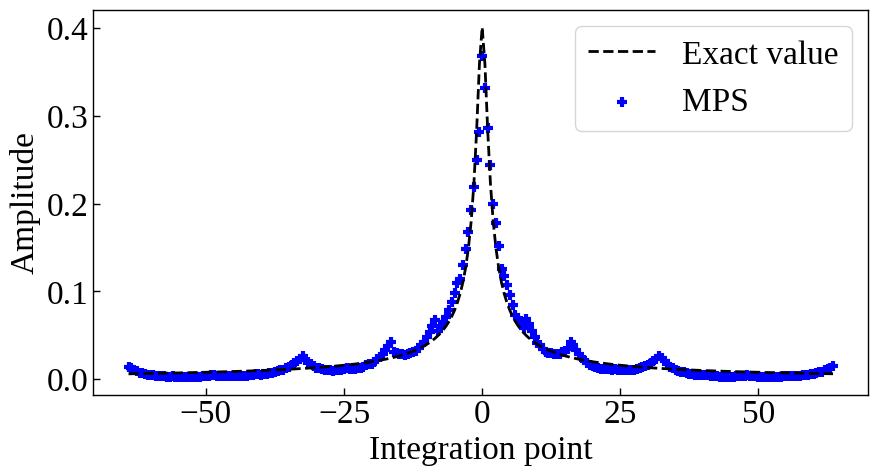

In [4]:
# MPS approximation
sim = LinearCombinationHamiltonianSimulation(op, num_qubits_lcu=8, lsb_pos=-1)
sim._get_lcu_state_preparation_circ(r_newton=10, r_inv=2)

# Exact values
k = np.arange(0, 2**sim._num_qubits_lcu) * 2**sim._lsb_pos
k[2**(sim._num_qubits_lcu-1):] -= 2**(sim._num_qubits_lcu + sim._lsb_pos)
vv = 2**(0.5*sim._lsb_pos) / np.sqrt(1 + k**2) / np.sqrt(np.pi)

# LCU coefficients approximated by MPS
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.sort(k), (vv / np.linalg.norm(vv))[np.argsort(k)], linestyle='dashed', linewidth=2.0, color='black', label='Exact value')
ax.scatter(k, sim.kernel_mps.matricize().real, s=50, c='blue', marker='+', label='MPS')
ax.set_xlabel('Integration point')
ax.set_ylabel('Amplitude')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

In [5]:
# Fidelity for various settings of the number of qubits and the rank of MPS
na_list = [5, 6, 7, 8, 9, 10]
r_inv_list = [2, 4, 8]

fidelity_list = []
for na in na_list:
    fidelity_tmp = []
    for r_inv in r_inv_list:

        sim = LinearCombinationHamiltonianSimulation(op, num_qubits_lcu=na, lsb_pos=-1)
        sim._get_lcu_state_preparation_circ(r_newton=10, r_inv=r_inv)
        k = np.arange(0, 2**sim._num_qubits_lcu) * 2**sim._lsb_pos
        k[2**(sim._num_qubits_lcu-1):] -= 2**(sim._num_qubits_lcu + sim._lsb_pos)
        vv = 2**(0.5*sim._lsb_pos) / np.sqrt(1 + k**2) / np.sqrt(np.pi)

        fidelity = np.abs(np.dot(sim.kernel_mps.matricize(), vv / np.linalg.norm(vv)))**2
        fidelity_tmp.append(fidelity)
    fidelity_list.append(fidelity_tmp)

Text(0, 0.5, 'Bond dimensions')

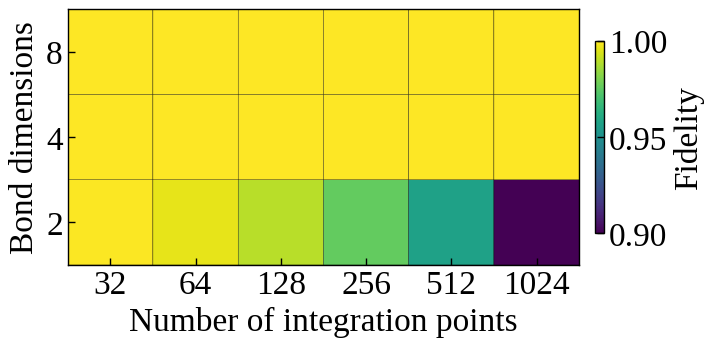

In [6]:
cmap = 'viridis'
norm = mcolors.Normalize(vmin=0.9, vmax=1.0)
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.pcolor(np.arange(len(na_list)), np.arange(len(r_inv_list)), 
          np.asarray(fidelity_list).transpose(), 
          shading="auto", norm=norm, cmap=cmap, edgecolor='k')
ax.set_aspect('equal')
pp = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), 
                  ax=ax, pad=0.025, shrink=0.5, label='Fidelity')
ax.set_xticks(np.arange(len(na_list)))
ax.set_yticks(np.arange(len(r_inv_list)))
ax.set_xticklabels([2**n for n in na_list])
ax.set_yticklabels(r_inv_list)
ax.set_xlabel('Number of integration points')
ax.set_ylabel('Bond dimensions')